In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [24]:
df = pd.read_csv("../Data/Modeling_dataset/credit_PRO.csv")

# Czyszczenie danych
Zajmujemy sie anomaliami i bledami wykrytymi podczas EDA 

usuwamy odstajace obserwacje z kolumny AMT_INCOME_TOTAL

In [25]:
data = df['AMT_INCOME_TOTAL']
print('Wejściowy rozmiar: ', data.shape[0])
upper_lim = data.quantile(.99)
df = df[( df.AMT_INCOME_TOTAL< upper_lim)]
print('Wyjściowy rozmiar: ', df.shape[0])

Wejściowy rozmiar:  14000
Wyjściowy rozmiar:  13860


-Błędne wartosci w kolumnie DAYS_EMPLOYED mozemy uzupełnić średnią
czy to dobre rozwiazanie? osoby z błędną dana maja problem ze splata w 13% czyli mniej niz w calej populacji
mozemy uzupełnić średnią i dodać dodatkową kolumnę oznaczającą błąd w danych

In [26]:
X = df.drop(["TARGET"],axis = 1)
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature engineering

- poprawienie błędnych i brakujacych wartosci
- transformacje
- skalowanie zmiennych
- wybieranie najbardziej wartosciowych kolumn
- tworzenie nowych zmiennych


## sprawdzamy jakosc kolumn numerycznych w przewidywaniu TARGET

In [27]:
target_column = "TARGET"
num_columns=['AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
df3 = df.loc[(df.DAYS_REGISTRATION!=0)&(df.DAYS_ID_PUBLISH!=0)]
df3 =df3.dropna(axis=0)
m  = -2
im= ""
jm=""
for i in num_columns:
    df3[f'{i}_category'] = pd.qcut(df3[i], q=5, labels=False, duplicates='drop')
    for j in num_columns:
        df3[f" {i} / {j}"] =df3[i]/df3[j]
df3 =df3.dropna(axis=1)
df3 =df3.drop(num_columns,axis=1)

In [28]:

Xt = df3.drop(["TARGET"],axis = 1)
yt = df3["TARGET"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel1 = SelectKBest(score_func=f_classif, k=10)
sel1.fit_transform(X_train_t, y_train_t)


C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 6 17 28 39 50 61 72 83 94] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array([[ 1.46402000e+05,  2.00000000e+00,  1.11880000e+00, ...,
         0.00000000e+00, -5.70545320e-01,  1.00000000e+00],
       [ 1.42309000e+05,  2.00000000e+00,  1.10560000e+00, ...,
         4.00000000e+00, -3.48312579e-01,  2.00000000e+00],
       [ 1.07008000e+05,  2.00000000e+00,  1.26400000e+00, ...,
         4.00000000e+00, -6.56158244e-01,  4.00000000e+00],
       ...,
       [ 1.44726000e+05,  2.00000000e+00,  1.52800000e+00, ...,
         2.00000000e+00, -1.52417062e+00,  0.00000000e+00],
       [ 1.00108000e+05,  2.00000000e+00,  1.21120000e+00, ...,
         3.00000000e+00, -4.08456781e-01,  4.00000000e+00],
       [ 1.35568000e+05,  2.00000000e+00,  1.00000000e+00, ...,
         3.00000000e+00, -7.71492235e-01,  1.00000000e+00]])

In [29]:
a = df3.columns.tolist()
[a[i] for i, value in enumerate(sel1.get_support()) if value]

['id',
 'FLAG_WORK_PHONE',
 ' AMT_CREDIT / AMT_ANNUITY',
 ' AMT_ANNUITY / DAYS_BIRTH',
 ' AMT_GOODS_PRICE / AMT_INCOME_TOTAL',
 ' AMT_GOODS_PRICE / AMT_CREDIT',
 ' REGION_POPULATION_RELATIVE / AMT_CREDIT',
 ' REGION_POPULATION_RELATIVE / DAYS_ID_PUBLISH',
 ' DAYS_BIRTH / AMT_CREDIT',
 ' DAYS_REGISTRATION / DAYS_ID_PUBLISH']

In [30]:
df2 = df[num_columns+["TARGET"]]
df2 = df2.dropna(axis = 0)
Xt = df2.drop(["TARGET"], axis = 1)
yt = df2["TARGET"]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.2, random_state=42, stratify=yt)

sel2 = SelectKBest(score_func=f_classif,k=5)
sel2.fit_transform(X_train_t, y_train_t)

array([[ 6.7500e+05,  4.9600e-03, -2.3053e+04, -1.0481e+04, -3.4930e+03],
       [ 2.7000e+05,  1.0276e-02, -1.2092e+04, -2.3270e+03, -4.1330e+03],
       [ 1.3500e+06,  1.8801e-02, -1.0204e+04, -4.6810e+03, -2.8650e+03],
       ...,
       [ 1.2060e+06,  2.8663e-02, -2.0629e+04, -9.2580e+03, -3.5720e+03],
       [ 6.8850e+05,  7.3300e-03, -1.0107e+04, -3.9300e+03, -2.7780e+03],
       [ 6.8850e+05,  6.2070e-03, -1.7717e+04, -9.0500e+03, -1.2550e+03]])

In [31]:
a = df2.columns.tolist()
b =[a[i] for i, value in enumerate(sel2.get_support()) if value]
columns_to_subtract = [x for x in num_columns if x not in b]


## Tworzymy transformer, aby zautomatyzować preprocessing danych

In [32]:
goods_price_impute = X_train['AMT_GOODS_PRICE'].dropna().median()
days_employed_impute = df.loc[df["DAYS_EMPLOYED"]<0].DAYS_EMPLOYED.mean()
days_employed_impute

-2350.6807458803123

In [33]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, Xc, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        # modify cnt children
        Xc.loc[X['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4
        
        # impute missing values
        Xc['AMT_GOODS_PRICE'] = Xc['AMT_GOODS_PRICE'].fillna(goods_price_impute)

        # impute bad values in DAYS_EMPLOYED and add column indicating it
        Xc['BAD_DAYS_EMPLOYED'] = (Xc['DAYS_EMPLOYED'] > 0).astype(int)
        Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute

         # stworzenie nowych zmiennych todo
        Xc[' AMT_CREDIT / AMT_ANNUITY'] = Xc.AMT_CREDIT / Xc.AMT_ANNUITY
        Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = Xc.AMT_ANNUITY / Xc.DAYS_BIRTH
        Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] =Xc.AMT_GOODS_PRICE / Xc.AMT_INCOME_TOTAL
        Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = Xc.AMT_GOODS_PRICE / Xc.AMT_CREDIT
        
        # log transforms
        # Xc["AMT_CREDIT"] = np.log1p(Xc["AMT_CREDIT"])
        # Xc["AMT_INCOME_TOTAL"] = np.log1p(Xc["AMT_INCOME_TOTAL"])
        # Xc["AMT_ANNUITY"] = np.log1p(Xc["AMT_ANNUITY"])
        Xc["AMT_GOODS_PRICE"] = np.log1p(Xc["AMT_GOODS_PRICE"])
        
        # skalowanie zmiennych
        s = StandardScaler()
        # Xc["AMT_CREDIT"] = s.fit_transform(Xc[["AMT_CREDIT"]])
        # Xc["AMT_INCOME_TOTAL"] = s.fit_transform(Xc[["AMT_INCOME_TOTAL"]])
        # Xc["AMT_ANNUITY"] = s.fit_transform(Xc[["AMT_ANNUITY"]])
        Xc["AMT_GOODS_PRICE"] = s.fit_transform(Xc[["AMT_GOODS_PRICE"]])
        # Xc[' AMT_CREDIT / AMT_ANNUITY'] = s.fit_transform(Xc[[' AMT_CREDIT / AMT_ANNUITY']]) # tutaj przeskalowanie zmiennych znaczaca metryki modelu
        # Xc[ ' AMT_ANNUITY / DAYS_BIRTH'] = s.fit_transform(Xc[[ ' AMT_ANNUITY / DAYS_BIRTH']])
        # Xc[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_INCOME_TOTAL']])
        # Xc[' AMT_GOODS_PRICE / AMT_CREDIT'] = s.fit_transform(Xc[[' AMT_GOODS_PRICE / AMT_CREDIT']])

        # wybranie najlepszych kolumn todo
        Xc = Xc.drop(["id",'HOUR_APPR_PROCESS_START']+columns_to_subtract, axis=1)
        

        
        return Xc

# Pierwszy model i baseline

In [34]:
pipeline = Pipeline([
    ('transformer', Transformer()),
    ("estimator", LogisticRegression())
])

In [35]:
pipeline.fit(X_train,y_train)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer', Transformer()),
                ('estimator', LogisticRegression())])

In [36]:
y_pred = pipeline.predict(X_test)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[2276    0]
 [ 496    0]]
Balanced Accuracy: 0.5
Accuracy: 0.8210678210678211


C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


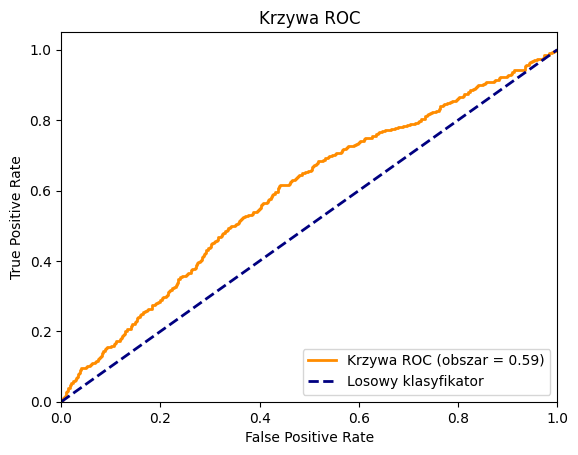

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

- baseline_acc = 0.82
- baseline_balance_acc = 0.5

# Oversampling

In [39]:
pipeline1 = ImbPipeline([
    
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('transformer', Transformer(), X_train.columns),
        ],
        remainder='passthrough'
    )),
    ('oversampler', SMOTE()),
    ("estimator", LogisticRegression())
])

In [40]:
pipeline1.fit(X_train,y_train)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute
C:\Users\bartekb\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer', Transformer(),
                                                  Index(['id', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START'],
      dtype='object'))])),
                ('oversampler', SMOTE()), ('estimator', LogisticRegression())])

In [41]:
y_pred = pipeline1.predict(X_test)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1312  964]
 [ 204  292]]
Balanced Accuracy: 0.5825797947729463
Accuracy: 0.5786435786435786


In [43]:
# conf_matrix[0,0]*m-conf_matrix[1,0]*m

C:\Users\bartekb\AppData\Local\Temp\ipykernel_2796\1748135882.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2350.6807458803123' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xc.loc[Xc["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED'] = days_employed_impute


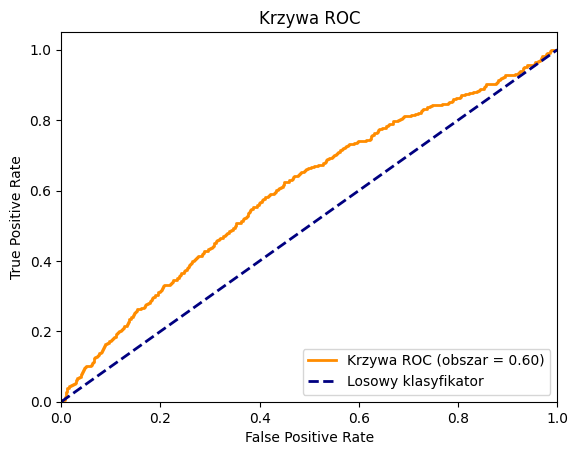

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test,pipeline1.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()
